# Deep Q Learning implementation on CartPole game

## The Game

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center. If the episode has not ended after 500 time steps, the game is won.

![SegmentLocal](img/cartpole.gif "segment")

Let's train an agent to win the game, using Deep Q Learning and some associated tricks mentionned in the course.

To be able to successfully train our model during this short session, we will not work on the frames (h x w pixels) of the game, but on synthetic data (4 x 1 vector) describing the state of the environement at each time step.

## Observe random agent

Before we create a smart agent able to solve the game, let's observe how an agent taking decisions randomly would act in the environment.

To do so, execute the python file **random_render.py**, located in the same directory as this notebook.

<img src="img/console_random.JPG" alt="Drawing" style="width: 400px;"/>

Let's begin!

## Import stuff

In [1]:
import numpy as np
import pandas as pd
import random
from IPython import display
from collections import namedtuple, deque
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cpu")

import gym

## Initialize environment

In [2]:
env = gym.make("CartPole-v1")
env.seed(0)
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

ram_dimensions = env.observation_space.shape[0]
nb_actions = env.action_space.n
print('\nRam information received from CartPole-v1 will has %d dimensions.' % ram_dimensions)
print('There are %d possible actions at each step.' % nb_actions)


Ram information received from CartPole-v1 will has 4 dimensions.
There are 2 possible actions at each step.


## Define neural network architecture

We chose a simple architecture with one fully connected hidden layer (32 units) activated with RELU.

<img src="img/architecture.JPG" alt="Drawing" style="width: 400px;"/>

In [3]:
class QNetwork(nn.Module):
    """Agent (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_units=32):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in first hidden layer
        """
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        return self.fc2(x)

## Create Experience Replay object (aka ReplayBuffer)

In [4]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Create Agent class (decision making and learning mechnisms)

#### Hyperparameters

In [5]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 60                # for update of target network parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

#### Agent class

In [6]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size):
        """Initialize an Agent object.
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """
        self.state_size = state_size
        self.action_size = action_size

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step += 1
        if self.t_step%UPDATE_EVERY == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        #Update target network weights every TAU learning steps (so every TAU*UPDATE_EVERY t_step)
        if self.t_step%(TAU*UPDATE_EVERY)==0:
            self.update_target_net(self.qnetwork_local, self.qnetwork_target)                     

    def update_target_net(self, local_model, target_model):
        """Soft update model parameters.
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
        """
        target_model.load_state_dict(local_model.state_dict())

## Create Agent instance

In [7]:
agent = Agent(state_size=ram_dimensions, action_size=nb_actions)

## Define main loop function

In [8]:
def dqn(n_episodes=2000, max_t=500, eps_start=1.0, eps_end=0.01, eps_decay=0.997, solved=495):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    start = time.time()                # Start time
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    list_eps = []
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        # Reset env and score at the beginning of episode
        state = env.reset() # reset the environment and get current state
        score = 0 # initialize the score
        
        for t in range(max_t):

            action = agent.act(state, eps)
    
            next_state, reward, done, _ = env.step(action)      # send the action to the environment

            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break


        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        list_eps.append(eps)
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        if i_episode % 100 == 0:
            print('\rEpisode {}/{} \tAverage Score: {:.2f}'.format(i_episode, n_episodes, np.mean(scores_window)))
            print('Epsilon: {}'.format(eps))
            
        if np.mean(scores_window)>solved:
            print('Game Solved after {} episodes'.format(i_episode))
            break

    time_elapsed = time.time() - start
    print("Time Elapse: {:.2f} seconds".format(time_elapsed))
    
    return scores, list_eps

## Train and visualize results

In [9]:
scores, list_eps = dqn(n_episodes=2000)

Episode 100/2000 	Average Score: 18.21
Epsilon: 0.7404842595397826
Episode 200/2000 	Average Score: 14.05
Epsilon: 0.5483169386261801
Episode 300/2000 	Average Score: 13.40
Epsilon: 0.4060200622917276
Episode 400/2000 	Average Score: 14.88
Epsilon: 0.30065146518438607
Episode 500/2000 	Average Score: 12.43
Epsilon: 0.2226276775766107
Episode 600/2000 	Average Score: 54.46
Epsilon: 0.164852290983378
Episode 700/2000 	Average Score: 65.71
Epsilon: 0.12207052662226334
Episode 800/2000 	Average Score: 111.11
Epsilon: 0.09039130351751799
Episode 900/2000 	Average Score: 240.90
Epsilon: 0.06693333745400507
Episode 1000/2000 	Average Score: 398.22
Epsilon: 0.04956308282315532
Episode 1100/2000 	Average Score: 475.55
Epsilon: 0.036700682684813045
Game Solved after 1144 episodes
Time Elapse: 75.79 seconds


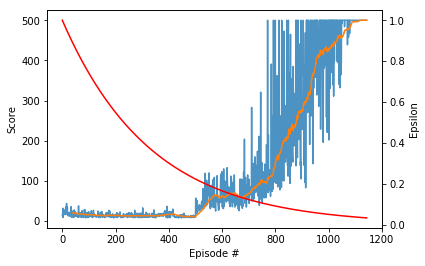

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
p = pd.Series(scores)
ma = p.rolling(40).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.ylabel('Score')
plt.xlabel('Episode #')

ax2 = ax.twinx()
ax2.set_ylabel('Epsilon')  # we already handled the x-label with ax1
ax2.plot(pd.Series(list_eps), color="r")
plt.show()

## Test results without any random exploration

In [11]:
def test_agent(agent, max_steps=500, n_episodes=100):
    env = gym.make("CartPole-v1")
    ram_dimensions = env.observation_space.shape[0]
    nb_actions = env.action_space.n
    
    scores = []
    
    for ep in range(n_episodes):
        state = env.reset()
        score = 0
        
        for i in range(max_steps):
            action = agent.act(state, eps = 0)
            state, reward, done, _ = env.step(action)
            score += reward
            if done:
                break
        scores.append(score)
        
    print("\n\nAverage score over {} episodes: {} / {}".format(n_episodes, np.round(np.mean(scores), 2), float(max_steps)))
    print("Standard deviation of scores over {} episodes: {}".format(n_episodes, np.round(np.std(scores), 2)))

In [12]:
test_agent(agent)



Average score over 100 episodes: 500.0 / 500.0
Standard deviation of scores over 100 episodes: 0.0


## Watch our agent play

### Option 1: Execution in termimal


#### Step 1: Save model parameters

In [ ]:
torch.save(agent.qnetwork_local.state_dict(), 'model_params.pt')

#### Step 2: Go in the same folder as this notebook and execute render.py 

<img src="img/console.JPG" alt="Drawing" style="width: 400px;"/>

##### CAUTION: 
If you make changes in the classes (_QNetwork_, _ReplayBuffer_, _Agent_), you need to do those same changes in the file ___render.py___ (else, parameters loading might crash).

### Option 2 (low frame rate but easy): in Jupyter Notebook

In [ ]:
env = gym.make('CartPole-v1')
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once

agent.qnetwork_local.eval()

done=False

state = env.reset()
score=0
for j in range(500):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    score += reward
    state = next_state
    if done:
        break

## Your turn to play

In this notebook, you have seen an implementation of a DQN, with Experience Replay, and Fixed Target.

### 1) Try to put *TAU*=1, and retrain another agent

##### Questions
- With this new hyperparameter, what have we changed? What is this implementation equivalent to?


- What can you notice ?



### 1) Try to put *BUFFER_SIZE*=1, *UPDATE_EVERY*=1 and *BATCH_SIZE*=1, and retrain another agent

Since you reduced the batch to 1, train for 100000 episodes instead of 2000. Set the *eps_decay* to 0.9999.

##### Questions
- With these new hyperparameters, what have we changed?


- What can you notice ?



### 3) Try to change the *learn* method in the *agent* class to implement Double DQN

Clue: you only need to think about how you compute the target

Do not forget to reset the hyperparameters:
<img src="img/hyperparam.JPG" alt="Drawing" style="width: 500px;"/>

If well implemented, you can expect to solve the environment in less than 1000 episodes, which is a significant gain.